<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-&amp;-Inits" data-toc-modified-id="Imports-&amp;-Inits-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports &amp; Inits</a></span></li><li><span><a href="#Data-&amp;-Model" data-toc-modified-id="Data-&amp;-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data &amp; Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Results" data-toc-modified-id="Results-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Ignite-Testing" data-toc-modified-id="Ignite-Testing-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Ignite Testing</a></span></li><li><span><a href="#NLPBook-Testing" data-toc-modified-id="NLPBook-Testing-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>NLPBook Testing</a></span></li></ul></li><li><span><a href="#Trained-Embeddings" data-toc-modified-id="Trained-Embeddings-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Trained Embeddings</a></span></li></ul></div>

# CBOW Training with Frankenstein Text

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import torch

from torch import nn
from torch import optim
from torch.utils.data import DataLoader

In [3]:
from ignite.engine import Events, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar

In [4]:
from consts import consts
from cbow.dataset import CBOWDataset, DataContainer
from cbow.model import CBOWClassifier, ModelContainer
from cbow.trainer import IgniteTrainer
consts

Namespace(batch_size=64, checkpointer_name='classifier', checkpointer_prefix='cbow', device='cuda:3', early_stopping_criteria=5, embedding_size=100, learning_rate=0.0001, metric_file=PosixPath('../data/books/work_dir/metrics.csv'), model_dir=PosixPath('../data/books/work_dir/models'), num_epochs=100, path=PosixPath('../data/books'), proc_dataset_csv=PosixPath('../data/books/frankenstein_with_splits.csv'), save_every=2, save_total=5, vectorizer_file=PosixPath('../data/books/work_dir/vectorizer.json'), work_dir=PosixPath('../data/books/work_dir'))

## Data & Model

In [5]:
df = pd.read_csv(consts.proc_dataset_csv)
dc = DataContainer(df, consts.vectorizer_file, consts.batch_size, is_load=True)

classifier = CBOWClassifier(dc.vocabulary_size, consts.embedding_size)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=consts.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

mc = ModelContainer(classifier, optimizer, loss_func, scheduler)

pbar = ProgressBar(persist=True)
metrics = {'accuracy': Accuracy(), 'loss': Loss(loss_func)}

## Training

In [ ]:
ig = IgniteTrainer(mc, dc, consts, pbar, metrics)
ig.run()

### Results

In [6]:
training_metrics = pd.read_csv(consts.metric_file)
training_metrics = training_metrics[:-1]

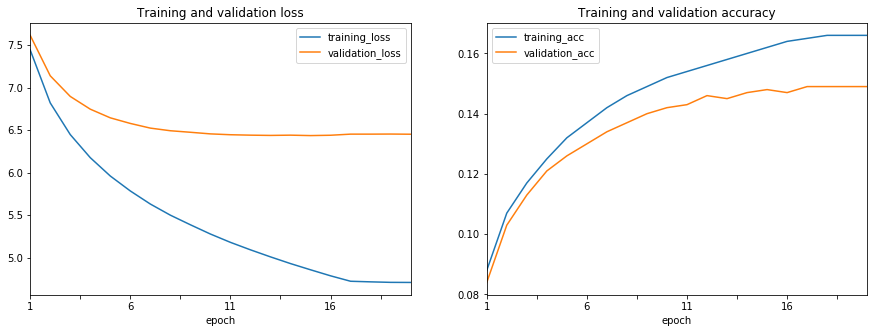

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
training_metrics.plot(x='epoch', y=['training_loss', 'validation_loss'], kind='line',
                      title='Training and validation loss', ax=axes[0])
training_metrics.plot(x='epoch', y=['training_acc', 'validation_acc'], kind='line',
                      title='Training and validation accuracy', ax=axes[1])

## Testing

### Ignite Testing

In [8]:
state_dict = torch.load(consts.work_dir/'cbow_classifier.pth')
classifier.load_state_dict(state_dict)
evaluator = create_supervised_evaluator(classifier, metrics=metrics)

@evaluator.on(Events.COMPLETED)
def log_testing_results(engine):
  metrics = engine.state.metrics
  print(f"Test loss: {metrics['loss']:0.3f}")
  print(f"Test accuracy: {metrics['accuracy']:0.3f}")

In [9]:
evaluator.run(dc.test_dl)

Test loss: 6.469
Test accuracy: 0.153


### NLPBook Testing

In [10]:
def compute_accuracy(y_pred, y_target):
  _, y_pred_indices = y_pred.max(dim=1)
  n_correct = torch.eq(y_pred_indices, y_target).sum().item()
  return n_correct / len(y_pred_indices) * 100

In [11]:
running_loss = 0.
running_acc = 0.

classifier.eval()
for i, batch in enumerate(dc.test_dl):
  x,y = batch
  y_pred = classifier(x_in=x)
  
  loss = loss_func(y_pred, y)
  loss_t = loss.item()
  running_loss += (loss_t-running_loss)/(i+1)
  
  acc_t = compute_accuracy(y_pred, y)
  running_acc += (acc_t-running_acc)/(i+1)

In [12]:
print(f"Test loss: {running_loss:0.3f}")
print(f"Test acc: {running_acc:0.3f}%")

Test loss: 6.468
Test acc: 15.338%


## Trained Embeddings

In [13]:
def pretty_print(results):
  for item in results:
    print(f"...{item[1]:0.2f} - {item[0]}")
    
def get_closest(target_word, idx_word_bidict, embedings, n=5):
  """
    Get the n closest words to the target word
  """
  # calculate distances to all other words
  word_embedding = embeddings[idx_word_bidict.inverse[target_word.lower()]]
  distances = []
  
  for idx, word in idx_word_bidict.items():
    if word == '<MASK>' or word == target_word:
      continue
    distances.append((word, torch.dist(word_embedding, embeddings[idx])))
    
  results = sorted(distances, key=lambda x: x[1])[1:n+2]
  return results

In [14]:
target_words = ['frankenstein', 'monster', 'hello', 'science', 'sickness', 'lonely', 'happy']
embeddings = classifier.embedding.weight.data
idx_word_bidict = dc.vocabulary.idx_token_bidict

for target_word in target_words:
  print(f"========={target_word}============")
  try:
    idx_word_bidict.inverse[target_word]
  except:
    print(f"Word {target_word} not in vocabulary")
    continue
  pretty_print(get_closest(target_word, idx_word_bidict, embeddings, n=5))

=========frankenstein============
...10.23 - florins
...10.33 - brawling
...10.58 - destroying
...10.69 - penalty
...10.90 - neat
...10.93 - glared
=========monster============
...10.50 - far
...10.58 - derive
...10.78 - frank
...11.07 - motion
...11.12 - september
...11.19 - bosom
=========hello============
Word hello not in vocabulary
=========science============
...10.53 - weather
...10.67 - under
...10.87 - physiognomy
...10.89 - villains
...10.91 - expeditions
...10.99 - summer
=========sickness============
...10.54 - meditate
...10.67 - incident
...10.72 - misdeed
...10.73 - thonon
...10.78 - french
...10.81 - confide
=========lonely============
...10.36 - complied
...10.48 - peace
...10.52 - dull
...10.83 - dew
...10.85 - volney
...10.88 - once
=========happy============
...11.57 - experiment
...11.72 - romance
...11.91 - escape
...11.93 - interest
...12.17 - preparations
...12.25 - edinburgh


In [ ]:
word = input("Enter a word: ")
embeddings = classifier.embedding.weight.data
idx_word_bidict = dc.vocabulary.idx_token_bidict
pretty_print(get_closest(word, idx_word_bidict, embeddings))